# Tutorial: Collecting messages from Telegram

## Set up 

[Telegram](https://telegram.org/) is a popular messaging application. This tutorial shows how you can collect messages from any public channel/group chat using the [Telethon library](https://docs.telethon.dev/en/stable/) in Python. But first, you will need a Telegram account linked to your mobile number and then get an API id and API Hash. 

<ins>Start by first:</ins>
1. Downloading the app
2. [Register](https://my.telegram.org/auth) your application and get your API id and API hash 
3. Store the credentials (id/hash) safely (you can store them in a .env file)
4. Install the telethon library.  This is an asyncio Python 3 library used to interact with Telegram's API. You can find some examples using asyncio [here](https://docs.telethon.dev/en/stable/concepts/asyncio.html).
```
python3 -m pip install --upgrade pip
python3 -m pip install --upgrade telethon
```

5. Install the asyncio library. This library allows you to do concurrent asynchronous programming in Python.

```
python3 -m pip install asyncio
```
6. You will have to update both IPython to 7.0+ and ipykernel to version 5.0+ for async to be available. (More details about using async in notebooks can be found [here](https://blog.jupyter.org/ipython-7-0-async-repl-a35ce050f7f7)). Note that Asyncio code can create some issues when using it in Jupyter Notebooks. There are some differences in the syntax that is written jupyter v/s a .py script. Also, according to Telethon's documentation: "When using Telethon with such interpreters, you are also more likely to get “sqlite3.OperationalError: database is locked” with them. If they cause too much trouble, just write your code in a .py file and run that, or use the normal python interpreter."


```
pip install IPython ipykernel --update

```



## Lets get started!

In [82]:
from telethon import TelegramClient
import pandas as pd
import json 
from pathlib import Path
import json
import os

from config import Config # I import the api id and hash from here 


In [54]:
# You can test the code by inputing your cridentials and uncommenting
# Ideally dont hardcode it here
# api_id = Config.api_id
# api_hash = Config.api_hash


## Some notes on concurrent programming & asyncio: 

### What does asyncronous mean?
The usual program in Python excutes code sequentially/synchronously --i.e.-- tasks/unit of work must complete before moving forward in the program. For example, a function must execute and provide a result before you can move on to your next task in the program. 

This is not required in asyncronous programming. Asynchronous programming is a type of parallel programming where you do not need to wait for a unit of work to complete before proceeding. For example, you can submit a HTTP request and while waiting for the HTTP request to finish/return response, you can do other work that’s waiting in a queue. 

*Note:* We are not doing multithreading. Instead, we have have a single thread and we are switching between tasks to utilize time more efficiently and not waste time waiting for tasks to complete. 

### Buikding blocks to do this:
### Coroutines?
This is a fuction which can pause and resume its execution at any stage.
To make such functions:
1. Simply put the *async* keyword at the beginning of your function 
```
async def my_coroutine():
    do something
    return
```
2. When you call such a function/coroutine, it will return a *coroutine object*. Unlike a normal function, this function has not been "executed" yet.
3. These coroutine objects *will* be executed using other means (using an *event loop*, explained below).

### Await keyword?
This keyword is used to pause the execution of a coroutine. We simply add the *await* keyword in front of the object you want to await. When the function encounters *await* --> function will stop there --> *awaitable object* will start running --> once the *awaitable object* completes --> then the remaining coroutine will proceed. 

```
async def my_coroutine():
    do something
    await something # wait for this task to complete
    do something else # proceed with the function
    return
```

When there are more than one coroutines, awaitable objects provide *context switching* ability or an "exit gate" through which we can switch between multiple coroutines. It allows you to run another coroutine during the period of delay created by await.

Awaitable objects can be coroutines, Tasks, Futures. *Tasks* allow you to schedule coroutines. You can convert a coroutine into a task (asyncio.create_task()) and schedule it to run concurrently. *Futures* allows represents a future result of an asynchronous operation.  

### Executing coroutines
We need an *event loop* which executes all the tasks which are passed to it. Generally runs in the main thread.

```
asyncio.run(my_coroutine())
```
Interpreters like Jupyter run the asyncio event loop implicitly, which is why we dont create it it below. All async functions must be scheduled for execution on the event loop instead of attempting to create a new loop in the same thread. Again, this is not the case when you execute code using a script (.py files). So, there will be some differences in the code between the two.




In [55]:
# Get credentials from the Config.py file 
api_id = Config.api_id
api_hash = Config.api_hash
session_name = Config.session_name

# Make a coroutine main()
# This function/coroutine takes in 
#  1. the name of the chat we want to collect 
#  2. the number of messages to collect 
# There are many other arguments you can pass (https://docs.telethon.dev/en/stable/modules/client.html?

async def main(chat_name, limit):
    # "async with" creates asynchronous context managers
    # It is an extension of the “with” expression for use only in coroutines within asyncio programs
    async with TelegramClient(session_name, api_id, api_hash) as client:
        
        # Get chat info 
        chat_info = await client.get_entity(chat_name)
        
        # Get all the messages, given the limit
        # It will return the latest 5 messages if limit is 5
        messages = await client.get_messages(entity=chat_info, limit=limit)
        
        # return the results in a dictionary
        return ({"messages": messages, "channel": chat_info})

    

In [56]:
# Collect the latest 1000 messages from nytimes Telegram channel (https://t.me/nytimes)
# This open an input box and ask you to input your phone number 
# and a code sent on the Telegram app the 1st time 
chat_input = "nytimes"
results = await main(chat_name = chat_input, limit=1000)

Please enter your phone (or bot token): +19253948793
Please enter the code you received: 28154
Signed in successfully as Ishita Gopal


In [57]:
# returns a dictionary with results 
results.keys()

dict_keys(['messages', 'channel'])

In [50]:
# Channel information 
# We can see for example, 
# 1. Its a channel
# 2. title is The New York Times
# 3. its verified
results["channel"].to_dict()

{'_': 'Channel',
 'id': 1606432449,
 'title': 'The New York Times',
 'photo': {'_': 'ChatPhoto',
  'photo_id': 4996942669779413476,
  'dc_id': 1,
  'has_video': False,
  'stripped_thumb': b'\x01\x08\x08\xce>O\xd8\x866\xf9\xb9\xe7\xaeh\xa2\x8a\x00'},
 'date': datetime.datetime(2022, 3, 9, 19, 25, 13, tzinfo=datetime.timezone.utc),
 'version': 0,
 'creator': False,
 'left': True,
 'broadcast': True,
 'verified': True,
 'megagroup': False,
 'restricted': False,
 'signatures': False,
 'min': False,
 'scam': False,
 'has_link': False,
 'has_geo': False,
 'slowmode_enabled': False,
 'call_active': False,
 'call_not_empty': False,
 'fake': False,
 'gigagroup': False,
 'access_hash': -1839593494233108316,
 'username': 'nytimes',
 'restriction_reason': [],
 'admin_rights': None,
 'banned_rights': None,
 'default_banned_rights': None,
 'participants_count': None}

In [95]:
# the results is a list which is 1000 items long 
len(results["messages"])

1000

In [96]:
results["messages"]

[<telethon.tl.patched.Message object at 0x119950640>, <telethon.tl.patched.Message object at 0x119950c40>, <telethon.tl.patched.Message object at 0x11a2e0610>, <telethon.tl.patched.Message object at 0x119ebca90>, <telethon.tl.patched.Message object at 0x119ebc430>, <telethon.tl.patched.Message object at 0x119ebc220>, <telethon.tl.patched.Message object at 0x11994eac0>, <telethon.tl.patched.Message object at 0x11994efd0>, <telethon.tl.patched.Message object at 0x11994e070>, <telethon.tl.patched.Message object at 0x11a2d35e0>, <telethon.tl.patched.Message object at 0x11a2d3d90>, <telethon.tl.patched.Message object at 0x119ec34f0>, <telethon.tl.patched.Message object at 0x119ec36a0>, <telethon.tl.patched.Message object at 0x119ee7700>, <telethon.tl.patched.Message object at 0x119ee7b50>, <telethon.tl.patched.Message object at 0x119ee75e0>, <telethon.tl.patched.Message object at 0x11a703550>, <telethon.tl.patched.Message object at 0x11a703400>, <telethon.tl.patched.Message object at 0x11a2

In [97]:
# convert the object to dictionary and look at what it returns
# lets look at the latest message
# It returns a lot of fields 
# like the message id, the date when the message was posted, its text, the associated media etc. 

results["messages"][0].to_dict()

{'_': 'Message',
 'id': 2195,
 'peer_id': {'_': 'PeerChannel', 'channel_id': 1606432449},
 'date': datetime.datetime(2023, 2, 23, 2, 58, 53, tzinfo=datetime.timezone.utc),
 'message': 'Putin and Biden Shore Up Alliances in Dueling Appearances\n\nIn a day of dueling efforts to shore up allegiances, President Biden wrapped up a three-day trip to Europe Wednesday with a promise of America’s commitment to its allies as President Vladimir V. Putin warmly welcomed China’s top diplomat to Moscow and rallied pro-war Russians.\n\nWith the anniversary of Moscow’s invasion of Ukraine approaching, Mr. Biden met in Warsaw with leaders from NATO’s eastern flank, acknowledging that “you know better than anyone what’s at stake in this conflict, not just for Ukraine, but for the freedom of democracies throughout Europe and around the world.” Read more\n\n@nytimes',
 'out': False,
 'mentioned': False,
 'media_unread': False,
 'silent': False,
 'post': True,
 'from_scheduled': False,
 'legacy': True,
 'e

In [98]:
# Lets get the text 
results["messages"][0].text

'[**Putin and Biden Shore Up Alliances in Dueling Appearances](https://nyti.ms/3m1VyVi)**\n\nIn a day of dueling efforts to shore up allegiances, President Biden wrapped up a three-day trip to Europe Wednesday with a promise of America’s commitment to its allies as President Vladimir V. Putin warmly welcomed China’s top diplomat to Moscow and rallied pro-war Russians.\n\nWith the anniversary of Moscow’s invasion of Ukraine approaching, Mr. Biden met in Warsaw with leaders from NATO’s eastern flank, acknowledging that “you know better than anyone what’s at stake in this conflict, not just for Ukraine, but for the freedom of democracies throughout Europe and around the world.” [**Read more](https://nyti.ms/3m1VyVi)**\n\n@nytimes'

In [100]:
# Lets save the results as json
msg_list = [msg.to_dict() for msg in results["messages"]]

# make json_data dir 
#Path(os.path.join("json_data")).mkdir(parents=True, exist_ok=True)

# Save results 
out_path = os.path.join(Config.output_dir, f"{chat_input}.json")
with open(out_path, "w") as f:
        json.dump(msg_list, f, default=str, ensure_ascii=False)


In [101]:
# Read in json file and convert the json to a pandas data frame 
nytimes_df = pd.read_json(out_path)

In [102]:
nytimes_df.head()

,_,id,peer_id,date,message,out,mentioned,media_unread,silent,post,...,reply_markup,entities,views,forwards,replies,edit_date,post_author,grouped_id,restriction_reason,ttl_period
0,Message,2195,"{'_': 'PeerChannel', 'channel_id': 1606432449}",2023-02-23 02:58:53+00:00,Putin and Biden Shore Up Alliances in Dueling ...,False,False,False,False,True,...,NaN,"[{'_': 'MessageEntityTextUrl', 'offset': 0, 'l...",3935,6,NaN,2023-02-23 02:59:41+00:00,NaN,NaN,[],NaN
1,Message,2194,"{'_': 'PeerChannel', 'channel_id': 1606432449}",2023-02-22 20:10:52+00:00,Russia stages a patriotic concert to rally sup...,False,False,False,False,True,...,NaN,"[{'_': 'MessageEntityTextUrl', 'offset': 0, 'l...",9028,24,NaN,2023-02-22 20:11:10+00:00,NaN,NaN,[],NaN
2,Message,2193,"{'_': 'PeerChannel', 'channel_id': 1606432449}",2023-02-22 14:08:20+00:00,"In a meeting with China’s top diplomat, Putin ...",False,False,False,False,True,...,NaN,"[{'_': 'MessageEntityTextUrl', 'offset': 0, 'l...",12197,20,NaN,2023-02-22 14:08:58+00:00,NaN,NaN,[],NaN
3,Message,2192,"{'_': 'PeerChannel', 'channel_id': 1606432449}",2023-02-22 10:25:23+00:00,Explosions boom in Kharkiv as Ukraine braces f...,False,False,False,True,True,...,NaN,"[{'_': 'MessageEntityTextUrl', 'offset': 0, 'l...",12988,9,NaN,2023-02-22 10:25:33+00:00,NaN,NaN,[],NaN
4,Message,2191,"{'_': 'PeerChannel', 'channel_id': 1606432449}",2023-02-22 00:08:51+00:00,Ukrainian schools plan to operate remotely the...,False,False,False,False,True,...,NaN,"[{'_': 'MessageEntityTextUrl', 'offset': 0, 'l...",15724,25,NaN,2023-02-22 00:09:26+00:00,NaN,NaN,[],NaN


In [103]:
nytimes_df["just_date"] = pd.to_datetime(nytimes_df.date).dt.date

In [107]:
# date range
f"{nytimes_df.just_date.min()} - {nytimes_df.just_date.max()}"

'2022-08-19 - 2023-02-23'

In [122]:
# Daily frequency of messages 
daily_count = nytimes_df.groupby("just_date").size().reset_index(name="freq")
daily_count.head()

,just_date,freq
0,2022-08-19,2
1,2022-08-20,6
2,2022-08-21,6
3,2022-08-22,10
4,2022-08-23,5


<AxesSubplot:xlabel='Date'>

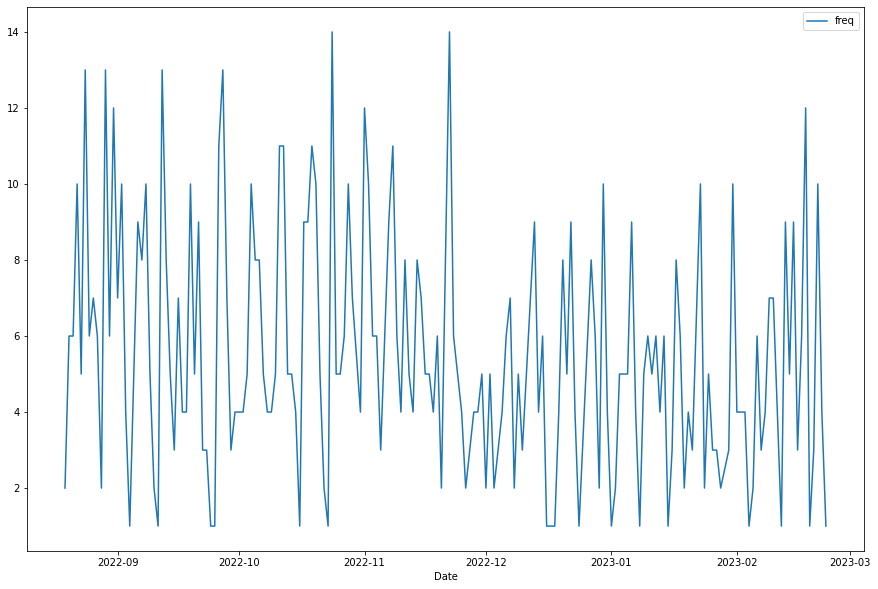

In [123]:
# plot Freq of messages 
daily_count.plot(x="just_date", y="freq", xlabel="Date", figsize= (15, 10))

In [125]:
# Post 5 messages daily on average in the last 7 months
daily_count.freq.mean() 

5.555555555555555